In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import gc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from scipy import stats
import joblib

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# Data paths
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'
SUBMISSION_PATH = 'submission.csv'

# Load data
print("Loading data...")
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nTrain columns: {train.columns.tolist()}")
print(f"\nFirst few rows of train:")
display(train.head())
print(f"\nFirst few rows of test:")
display(test.head())
print(f"\nTrain info:")
train.info()

Loading data...
Train shape: (630000, 13)
Test shape: (270000, 12)

Train columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']

First few rows of train:


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0



First few rows of test:


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate



Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB


## Adım 1: Numerik Değişkenlerin Korelasyonu
Önce sadece sayısal değişkenler arasındaki ilişkiye bakalım.

Numerik kolonlar: ['id', 'age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']


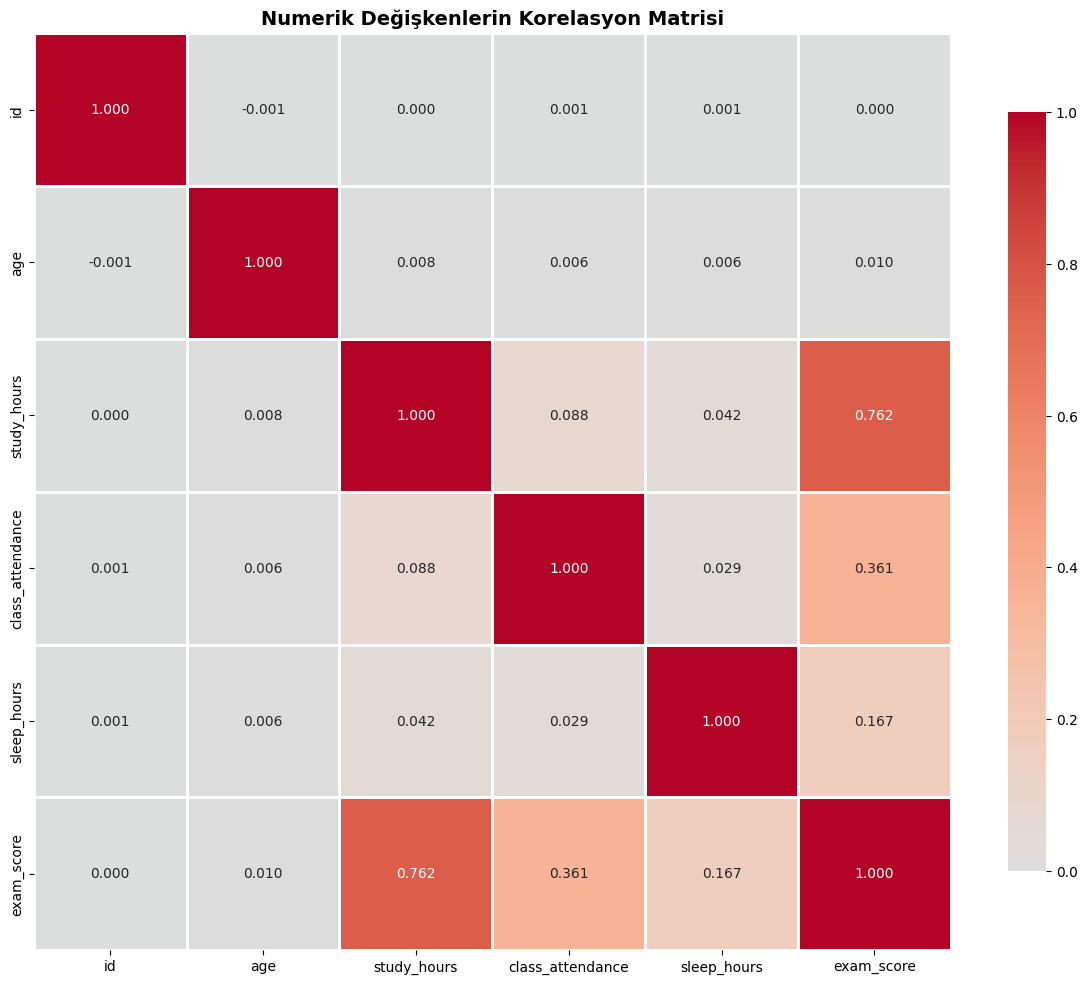


exam_score ile Korelasyonlar (Yüksekten Düşüğe):
exam_score          1.000000
study_hours         0.762267
class_attendance    0.360954
sleep_hours         0.167410
age                 0.010472
id                  0.000372
Name: exam_score, dtype: float64


In [3]:
# Numerik kolonları belirle
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerik kolonlar: {numeric_cols}")

# Numerik değişkenlerin korelasyonu
numeric_corr = train[numeric_cols].corr()

# Korelasyon matrisi görselleştirme
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Numerik Değişkenlerin Korelasyon Matrisi', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# exam_score ile korelasyonları göster
print("\n" + "="*50)
print("exam_score ile Korelasyonlar (Yüksekten Düşüğe):")
print("="*50)
score_corr = numeric_corr['exam_score'].sort_values(ascending=False)
print(score_corr)

## Adım 2: Kategorik Değişkenleri Encode Et
Şimdi kategorik verileri sayılara çevirelim (Label Encoding kullanarak).

In [4]:
# Kategorik kolonları belirle
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
print(f"Kategorik kolonlar: {categorical_cols}")

# Basit feature engineering (oran/etkileşim)
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['study_efficiency'] = df['study_hours'] / (df['class_attendance'] + 1.0)
    df['study_sleep_ratio'] = df['study_hours'] / (df['sleep_hours'] + 1.0)
    df['study_x_attendance'] = df['study_hours'] * df['class_attendance']
    df['sleep_x_study'] = df['sleep_hours'] * df['study_hours']
    return df

train_fe = add_features(train)
test_fe = add_features(test)

# Train ve test için kopyalar oluştur
train_encoded = train_fe.copy()
test_encoded = test_fe.copy()

print(f"\nTrain encoded shape: {train_encoded.shape}")
print(f"Test encoded shape: {test_encoded.shape}")

Kategorik kolonlar: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']

Train encoded shape: (630000, 17)
Test encoded shape: (270000, 16)


## Target Encoding (K-Fold safe)
Aşağıdaki hücre K-Fold out-of-fold target encoding uygular. Bu, target değerinin sızıntısını önlemek için her fold için yalnızca train fold'unda hesaplanan ortalamaları kullanır; test için ise tamamı üzerinde hesaplanan düzenlenmiş (smoothed) ortalama kullanılır.

In [5]:
from sklearn.model_selection import KFold

def target_encode_oof(train_df, test_df, cols, target='exam_score', n_splits=5, alpha=10, random_state=42):
    """K-Fold out-of-fold target encoding with smoothing."""
    train = train_df.copy()
    test = test_df.copy()
    global_mean = train[target].mean()

    for col in cols:
        print(f"Target-encoding: {col}")
        oof = np.zeros(len(train))
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        for tr_idx, val_idx in kf.split(train):
            tr_fold = train.iloc[tr_idx]
            val_fold = train.iloc[val_idx]

            stats = tr_fold.groupby(col)[target].agg(['mean','count'])
            smooth = (stats['mean'] * stats['count'] + global_mean * alpha) / (stats['count'] + alpha)
            mapping = smooth.to_dict()

            oof[val_idx] = val_fold[col].map(mapping).fillna(global_mean)

        stats_full = train.groupby(col)[target].agg(['mean','count'])
        smooth_full = (stats_full['mean'] * stats_full['count'] + global_mean * alpha) / (stats_full['count'] + alpha)
        mapping_full = smooth_full.to_dict()

        train[col + '_te'] = oof
        test[col + '_te'] = test[col].map(mapping_full).fillna(global_mean)

    return train, test

# Hangi kategorik kolonlara target encoding uygulayacağımızı seç
te_cols = [c for c in categorical_cols if c not in ['id']]

# Uygula (küçük alpha -> daha az shrinkage)
train_encoded, test_encoded = target_encode_oof(train_encoded, test_encoded, te_cols, n_splits=5, alpha=20)

# Raw kategorikleri düşür: sadece numerik + TE kalsın
train_encoded = train_encoded.drop(columns=te_cols)
test_encoded = test_encoded.drop(columns=te_cols)

print('\nTarget encoding tamamlandı. Yeni sütun örnekleri:')
print([c for c in train_encoded.columns if c.endswith('_te')][:20])
print(f"Train columns after drop: {train_encoded.shape}")
print(f"Test columns after drop: {test_encoded.shape}")

# Not: Eğer çok fazla kategori varsa memory/time artabilir; istersen sadece belirli yüksek-kardinalite kolonları seçebilirsin.

Target-encoding: gender
Target-encoding: course
Target-encoding: internet_access
Target-encoding: sleep_quality
Target-encoding: study_method
Target-encoding: facility_rating
Target-encoding: exam_difficulty

Target encoding tamamlandı. Yeni sütun örnekleri:
['gender_te', 'course_te', 'internet_access_te', 'sleep_quality_te', 'study_method_te', 'facility_rating_te', 'exam_difficulty_te']
Train columns after drop: (630000, 17)
Test columns after drop: (270000, 16)


## K-Fold Doğrulama ve Nihai Eğitim
- Kaggle tarzı değerlendirme için train verisini K-Fold (örn. 5 fold) ile doğrulamak yaygın pratik.
- Aşağıdaki hücre 5-fold RMSE ortalamasını hesaplar, ardından tüm veriyle eğitip test için `submission.csv` üretir.

In [6]:
# 5-Fold CV ile RMSE ölçümü ve final model
from sklearn.model_selection import KFold

all_features = [c for c in train_encoded.columns if c not in ['id', 'exam_score']]
X = train_encoded[all_features]
y = train_encoded['exam_score']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmses = []

params = dict(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
 )

for fold, (tr_idx, va_idx) in enumerate(kf.split(X), start=1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric='rmse',
    )

    preds = model.predict(X_va)
    rmse = np.sqrt(mean_squared_error(y_va, preds))
    cv_rmses.append(rmse)
    print(f"Fold {fold} RMSE: {rmse:.4f}")

cv_mean, cv_std = np.mean(cv_rmses), np.std(cv_rmses)
print(f"CV RMSE mean±std: {cv_mean:.4f} ± {cv_std:.4f}")

# Tüm veriyle son model ve submission
final_model = lgb.LGBMRegressor(**params)
final_model.fit(X, y)

test_preds = final_model.predict(test_encoded[all_features])
submission = pd.DataFrame({
    'id': test_encoded['id'],
    'exam_score': test_preds
})

submission.to_csv(SUBMISSION_PATH, index=False)
print(f"submission kaydedildi: {SUBMISSION_PATH}, shape={submission.shape}")
print(submission.head())

Fold 1 RMSE: 8.7655
Fold 2 RMSE: 8.7698
Fold 3 RMSE: 8.7644
Fold 4 RMSE: 8.7825
Fold 5 RMSE: 8.7953
CV RMSE mean±std: 8.7755 ± 0.0118
submission kaydedildi: submission.csv, shape=(270000, 2)
       id  exam_score
0  630000   70.519747
1  630001   70.620595
2  630002   87.803987
3  630003   56.045853
4  630004   47.645402
